In [1]:
# !wget http://images.cocodataset.org/zips/train2014.zip
# !mkdir data
# !unzip train2014.zip -d ./data >> /dev/null
# !wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
# !unzip annotations_trainval2014.zip -d . >> /dev/null

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

from torch.utils.data import Dataset, DataLoader

# from metricnew import metricx
# from colormetric import colormetricx

from feature_vae_res import FeatureVAE
from FVAE_helper import GradientReversalLayer, SimpleRegressor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from encoders import USEEncode, CLIPEncode, W2VEncode
from itertools import product
import os
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/Users/thomas/anaconda3/envs/new9/lib/python3.9/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/Users/thomas/anaconda3/envs/new9/lib/python3.9/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/Users/thomas/anaconda3/envs/new9/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/Users/thomas/anaconda3/envs/new9/lib/python3.9/site-packages

device(type='cpu')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from encoders import USEEncode, CLIPEncode, W2VEncode
from itertools import product

In [4]:
from pycocotools.coco import COCO
coco_caps=COCO('annotations/captions_train2014.json')
anns = coco_caps.loadAnns(coco_caps.getAnnIds(imgIds=np.sort(coco_caps.getImgIds())))
anns[:1]

loading annotations into memory...
Done (t=0.54s)
creating index...
index created!


[{'image_id': 9,
  'id': 661611,
  'caption': 'Closeup of bins of food that include broccoli and bread.'}]

In [5]:
non_given_dims = 700
im_size = 96
freeze_pretrained = True

rgb_supervise = False
rgb_supervise_start_epoch = 100
rgb_weak_supervise_prop = 0.1
rgb_pred_pretrain_epochs = 20

# beta for temperature sampling (by epoch). set to 0 to disable
rgb_temp_beta = 0.98
rgb_main_lr = 1e-5
rgb_lambda = 5
    
    
adversarial_supervise = False
# 20 or 30, depending
adversarial_lambda = 50
adversarial_target_language = True
adversarial_extra_train = 5

extra_reducer = False
extra_reducer_dim = 4

encoder_class = CLIPEncode
encoder_prompt = '{}'
encoder_model = None
weight_decay = 1e-5

beta = 1.0

num_epochs = 50
batch_size = 64
gradient_accumulation_steps = 1
lr = 1e-3
grad_clip = 1.0

updates_per_epoch = 1
num_displays = 3

In [6]:
rand_state = 420

torch.manual_seed(rand_state)
np.random.seed(rand_state)

In [7]:
name = 'shapes'
if encoder_class is W2VEncode:
    name = 'shapes_w2v'

In [8]:
# text_encoder = encoder_class(encoder_model, '{}')
# df = pd.DataFrame({'color': [b['caption'] for b in anns]})
# encoded_text = text_encoder.encode(df)
# torch.save(encoded_text, 'encoded_coco.pt')
# print(encoded_text.shape)

coco_embed = torch.load('encoded_coco.pt')

In [9]:
cap2im_id = []

for ann in anns:
    cap2im_id.append(ann['image_id'])
    
img_id2idx = dict()
for i, fname in enumerate(np.sort(os.listdir('data/train2014'))):
    img_id2idx[int(fname[15:27])] = i

for cap_i, im_id in enumerate(cap2im_id):
    cap2im_id[cap_i] = img_id2idx[im_id]

dataset = datasets.ImageFolder(root='data',
                   transform=transforms.Compose([
                       transforms.Resize((im_size, im_size)),
                       transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                   ]))

In [10]:
    
def to_img(x):
#     x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

class DatasetWrapper(Dataset):
    def __init__(self, img_dataset, text_embed):
        self.imgs = img_dataset
        self.text_embed = text_embed
        
    def __len__(self):
        return len(self.text_embed) // 10
    
    def __getitem__(self, idx):
        im = self.imgs[cap2im_id[idx]][0]
#         print(anns[idx])
        return (
            im.to(device), 
            self.text_embed[idx].to(device))
    

pair_dataset = DatasetWrapper(dataset, coco_embed)
train_size = round(len(pair_dataset) * 0.95)
valid_size = len(pair_dataset ) - train_size

train, valid = torch.utils.data.random_split(pair_dataset, [train_size, valid_size])

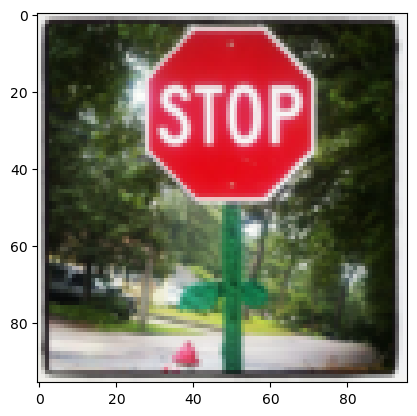

In [11]:
plt.imshow(to_img(train[28][0].permute(1, 2, 0)).cpu());

In [12]:
num_features = coco_embed.size(1)
num_features

512

In [13]:
bce_loss = nn.BCELoss(reduction='sum')
mse_loss = nn.MSELoss()
def vae_loss(x, mu, var, recon, beta):
    recon_loss = bce_loss(recon, x)
    kl = -torch.sum(1 + var - torch.pow(mu, 2) - torch.exp(var)) / 2
    return (recon_loss + beta * kl) / x.size(0)

SHARED_TEMP_VAR = [1.0]
def get_temp():
    return SHARED_TEMP_VAR[0]
def set_temp(t):
    SHARED_TEMP_VAR[0] = t

class TemperatureDataset(Dataset):
    def __init__(self, dataset1, dataset2, init_1_prob=1.0):
        # samples from dataset1 with init_1_prob, with temp decreasable by set_temp function
        # make sure only 1 of these is initialized at a time!
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.length = max(len(dataset1), len(dataset2))
        set_temp(init_1_prob)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        if np.random.rand() < get_temp():
            return self.dataset1[idx % len(self.dataset1)]
        return self.dataset2[idx % len(self.dataset2)]

In [14]:
# make all the dumb parameters / models / optimizers

extra_params = []

if extra_reducer:
    reducer = SimpleRegressor(num_features, extra_reducer_dim).to(device)
    num_features = extra_reducer_dim
    extra_params.append({'params': reducer.parameters()})

if rgb_supervise:
    z_dim = 3 + non_given_dims
else:
    z_dim = num_features + non_given_dims    

net = FeatureVAE(z_dim, 
                 3 if rgb_supervise else num_features, 
                 im_size=im_size, 
                 freeze_pretrained=freeze_pretrained).to(device)
extra_params.append({'params': net.parameters()})

if rgb_supervise:
    rgb_maker = SimpleRegressor(num_features, 3).to(device)
    extra_params.append({'params': rgb_maker.parameters(), 'lr': rgb_main_lr})
    
if adversarial_supervise:
    adversary = SimpleRegressor(non_given_dims, 
                                num_features if adversarial_target_language else 3).to(device)
    adv_optimizer = torch.optim.Adam(adversary.parameters(), lr=lr)
    GRL = GradientReversalLayer.apply

# optimizer = torch.optim.AdamW(extra_params, lr=lr)
optimizer = torch.optim.Adam(extra_params, lr=lr, weight_decay=False)

# train_dataset = DatasetWrapper(train, train_meta, train_color_rgb, train_has_rgb)
# valid_dataset = DatasetWrapper(valid, valid_meta, train_color_rgb, torch.zeros(len(valid)))

if rgb_supervise:
    rgb_dataset = DatasetWrapper(train[train_has_rgb.reshape(-1)], 
                       train_meta[train_has_rgb.reshape(-1)], 
                       train_color_rgb[train_has_rgb.reshape(-1)], 
                       train_has_rgb[train_has_rgb.reshape(-1)])
    if rgb_temp_beta:
        train_dataset = TemperatureDataset(rgb_dataset, train_dataset)

train_dataloader = DataLoader(
    train, 
    batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(
    valid, 
    batch_size=batch_size, shuffle=True)

num_batches = len(train_dataloader)
num_valid_batches = len(valid_dataloader)

In [15]:
# if we want to pretrain the weakly supervised rgb encoder (text to rgb), do so

if rgb_supervise and rgb_pred_pretrain_epochs:
    rgb_dataloader = DataLoader(
        rgb_dataset, 
        batch_size=batch_size, shuffle=True)
    print('pretraining rgb')
    rgb_optimizer = torch.optim.Adam(rgb_maker.parameters(), lr=lr)
    for epoch in tqdm(range(1, rgb_pred_pretrain_epochs+1)):
        # train rgb model
        for _, latent, rgb, _ in rgb_dataloader:
            rgb_optimizer.zero_grad()
            pred_rgb = rgb_maker(latent)
            loss = mse_loss(pred_rgb, rgb)
            loss.backward()
            rgb_optimizer.step()
        
        with torch.no_grad():
            # display some colors
            rand_color_idxs = np.random.randint(len(valid_color_rgb), size=num_displays)
            rand_colors = valid_color_rgb[rand_color_idxs].cpu().numpy()

            rand_color_features = valid_meta[rand_color_idxs].to(device)
            pred_rgb = rgb_maker(rand_color_features)

            fig, axes = plt.subplots(num_displays, 2)
            fig.suptitle('Target Color vs Predicted')
            fig.set_size_inches(6, 5)
            for j, ax in enumerate(axes):
                ax[0].imshow(rand_colors[j][None, None, :])
                ax[1].imshow(pred_rgb[j].cpu().numpy()[None, None, :])
            plt.show()

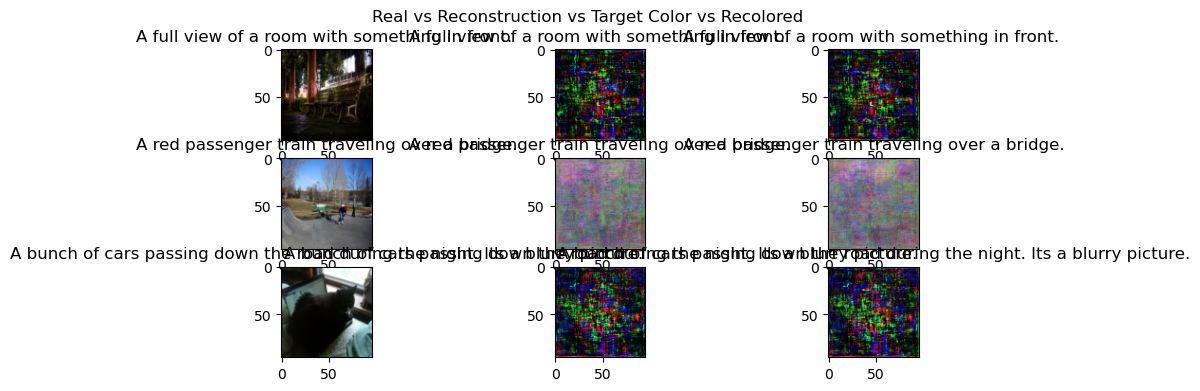

Epoch 2:  23%|██████▍                     | 141/615 [1:22:42<4:41:44, 35.66s/it]

In [ ]:
train_losses, valid_losses = [], []

rgb_losses, adversary_losses = [], []

update_idxs = set([i * (num_batches // updates_per_epoch)
    for i in range(1, updates_per_epoch)] + [num_batches])

best_valid = 1e9
for epoch in range(1, 1+num_epochs):
    total_loss = 0.0 

    pbar = tqdm(train_dataloader, desc=f"Epoch {epoch}", leave=False, total=num_batches)
    
    if adversarial_supervise and adversarial_extra_train:
        adversary_extra_loader = iter(train_dataloader)
    
    for idx, (x, latent_supervision) in enumerate(pbar, start=1):
        
        # extra training runs for adversary
        if adversarial_supervise and adversarial_extra_train:
            for _ in range(adversarial_extra_train):
                batch = next(adversary_extra_loader, None)
                if batch is None:
                    adversary_extra_loader = iter(train_dataloader)
                    batch = next(adversary_extra_loader, None)
                
                x2, latent_supervision2, rgb2, has_rgb2 = batch
                
                if extra_reducer:
                    latent_supervision2 = reducer(latent_supervision2)
                    
                with torch.no_grad():
                    supervision = latent_supervision2
                    if rgb_supervise:
                        # just need the shape to match: z is not directly dependent on rgb2
                        supervision = rgb2
                    recon, mu, var, z = net(x2, supervision)
                    
                adv_optimizer.zero_grad()
                pred_target = adversary(z.detach())
                loss = adversarial_lambda * mse_loss(pred_target, 
                            latent_supervision2 if adversarial_target_language else rgb2)
                loss.backward()
                adv_optimizer.step()
        
        # main train loop
        optimizer.zero_grad()
        
        if extra_reducer:
            latent_supervision = reducer(latent_supervision)
            
        supervision = latent_supervision
        loss = 0.0
        if rgb_supervise:
            pred_rgb = rgb_maker(latent_supervision)
            
            # penalize if predicted rgb is wrong
            
            loss = loss + rgb_lambda * mse_loss(has_rgb * pred_rgb + (
                ~has_rgb) * rgb, rgb)
            
            if epoch < rgb_supervise_start_epoch:
                supervision = has_rgb * rgb + (~has_rgb) * pred_rgb
            else:
                supervision = pred_rgb
#             supervision = rgb if epoch < rgb_supervise_start_epoch else pred_rgb
        
        recon, mu, var, z = net(x, supervision)
        try:
            loss += vae_loss(x, mu, var, recon, beta)
        except:
            print(x.max())
            print(recon.max())
        
        if adversarial_supervise:
            pred_target = adversary(GRL(z))
            loss = loss + adversarial_lambda * mse_loss(pred_target, 
                            latent_supervision if adversarial_target_language else rgb)

        total_loss += loss.item() / gradient_accumulation_steps
        loss = loss / gradient_accumulation_steps
        loss.backward()
        optimizer.step()

        if idx in update_idxs:
            avg_valid_loss = 0.0
            
            avg_adversary_loss, avg_rgb_loss = 0.0, 0.0
            
            displays = []
            net.eval()
            with torch.no_grad():
                for (x, latent_supervision) in valid_dataloader:
                    
                    if extra_reducer:
                        latent_supervision = reducer(latent_supervision)
                        
                    supervision = latent_supervision
                    
                    if rgb_supervise:
                        pred_rgb = rgb_maker(latent_supervision)
                        avg_rgb_loss += mse_loss(pred_rgb, rgb).item() / num_valid_batches
                        supervision = pred_rgb
                        
                    recon, mu, var, z = net(x, supervision)
                    
                    if adversarial_supervise:
                        avg_adversary_loss += mse_loss(adversary(z), 
                        latent_supervision if adversarial_target_language else rgb).item() / num_valid_batches
                    
                    avg_valid_loss += vae_loss(x, mu, var, recon, beta).item() / num_valid_batches
                    if not displays:
                        net.random_z = tuple(z[0].detach().cpu().numpy())
                        
                        rand_color_idxs = np.random.randint(len(coco_embed), size=num_displays)
                        rand_colors = coco_embed[rand_color_idxs].cpu().numpy()
                        
                        rand_color_features = coco_embed[rand_color_idxs].to(device)
                        if extra_reducer:
                            rand_color_features = reducer(rand_color_features)
                        
                        if rgb_supervise:
                            rand_color_features = rgb_maker(rand_color_features)
                        
                        recon2 = net.generate(z[:num_displays], rand_color_features)
                        
                        captions = [anns[col_idx]['caption'] for col_idx in rand_color_idxs]       
                        for j in range(num_displays):
                            displays.append((
                                x[j].permute(1, 2, 0).cpu().numpy(),
                                recon[j].permute(1, 2, 0).cpu().numpy(),
#                                 rand_colors[j][None, None, :],
                                recon2[j].permute(1, 2, 0).cpu().numpy()
                            )
                            )
                
                if avg_valid_loss < best_valid:
#                     torch.save(net, f'models/{beta}-featurevae-{z_dim}dim')
#                     curr_metrics = []
#                     curr_color_metrics = []
#                     for (x, latent_supervision, rgb, _) in valid_dataloader:
#                         if extra_reducer:
#                             latent_supervision = reducer(latent_supervision)

#                         supervision = latent_supervision

#                         if rgb_supervise:
#                             pred_rgb = rgb_maker(latent_supervision)
#                             avg_rgb_loss += mse_loss(pred_rgb, rgb).item() / num_valid_batches
#                             supervision = pred_rgb

#                         recon, mu, var, z = net(x, supervision)

#                         rand_color_idxs = np.random.randint(len(valid_color_rgb), size=x.shape[0])
#                         rand_colors = valid_color_rgb[rand_color_idxs].cpu().numpy()

#                         rand_color_features = valid_meta[rand_color_idxs].to(device)
#                         if extra_reducer:
#                             rand_color_features = reducer(rand_color_features)

#                         if rgb_supervise:
#                             rand_color_features = rgb_maker(rand_color_features)

#                         recon2 = net.generate(z, rand_color_features)
#                         curr_metrics.extend([
#                             metricx(pilable(r), pilable(xi))
#                             for r, xi in zip(recon, x)
#                         ])
#                         curr_color_metrics.extend([
#                             colormetricx(pilable(r), colorable(c))
#                             for r, c in zip(recon2, rand_colors)
#                         ])
                        
                    best_valid = avg_valid_loss
                    
                valid_losses.append(avg_valid_loss)
                rgb_losses.append(avg_rgb_loss)
                adversary_losses.append(avg_adversary_loss)
            
            net.train()


            pbar.set_description(f"Epoch {epoch} | train loss {total_loss / idx:.2f}" + \
                                f" | valid loss {avg_valid_loss:.2f}")
            train_losses.append(total_loss / idx)
    
    if rgb_supervise and rgb_temp_beta:
        new_temp = get_temp() * rgb_temp_beta
        print('setting weakly supervised temperature to', new_temp)
        set_temp(new_temp)
    
    fig, axes = plt.subplots(num_displays, 3)
    fig.suptitle('Real vs Reconstruction vs Target Color vs Recolored')
    fig.set_size_inches(10, 4)
    for ax, im, caption in zip(axes, displays, captions):
        for axi, imi in zip(ax, im):
            axi.imshow(imi)
            axi.set_title(caption)
    plt.show()

In [ ]:
# trial['img_metric_mean'] = np.mean(curr_metrics, axis=0)
# trial['img_metric_std'] = np.std(curr_metrics, axis=0)

# trial['color_metric_mean'] = np.mean(curr_color_metrics)
# trial['color_metric_std'] = np.std(curr_color_metrics)

In [ ]:
# plt.plot(train_losses, label='Train Loss')
# plt.plot(valid_losses, label='Valid Loss')

# plt.legend()
# plt.show()

# if rgb_supervise:
#     plt.plot(rgb_losses, label='RGB Valid Loss')
#     plt.legend()
#     plt.show()
    
# if adversarial_supervise:
#     plt.plot(adversary_losses, label='Adversary Valid Loss')
#     plt.legend()
#     plt.show()